In [1]:
from glob import glob

for g in glob("data/*.pdf"):
    print(g)


data\운동 전문 데이터_식이 조절_1차본.pdf


In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """주어진 PDF 파일을 읽고 텍스트를 분할합니다.
        매개변수:
            pdf_path (str): PDF 파일의 경로
            chunk_size (int): 각 청크의 최대 크기. 기본값은 1000
            chunk_overlap (int): 청크 간의 중복 크기. 기본값은 100
        반환값:
            list: 분할된 텍스트 청크의 리스트
    """
    pdf_loader = PyPDFLoader(file_path=pdf_path)
    data_from_pdf = pdf_loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    split_docs = text_splitter.split_documents(data_from_pdf)
    print(f'Nnmber of split:{len(split_docs)}\n')
    return split_docs

c:\Users\tjdfu\anaconda3\envs\chatbot\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import os

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

persist_directory = "chroma_store"

if os.path.exists(persist_directory):
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings
    )
else:
    print("Creating new vectorstore...")

    vectorstore = None

    for g in glob("data/*.pdf"):
        chunks = read_pdf_and_split_text(g)
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i+100],
                    embedding=embeddings,
                    persist_directory=persist_directory
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100]
                )

In [4]:
retriever = vectorstore.as_retriever(search_kwargs={"k":5})

# chunks = retriever.invoke("다이어트 방식에 대해서 알려줘")

# for c in chunks:
#     print(c.metadata)
#     print(c.page_content)

### 라우터 설정하기

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

class RoutuQuery(BaseModel):
    """사용자 쿼리를 가장 관령성이 높은 데이터 소스로 라우팅합니다."""
    
    datasource: Literal['vectorstore', 'casual_talk'] = Field(...,
                                                              description="""사용자 질문에 따라 casual_talk, 또는 vectorstore로 라우팅합니다.
                                                                            - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 떄 사용합니다. 
                                                                            - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.""")
    
structured_llm_router = model.with_structured_output(RoutuQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
-vectorstore에는 다이어트 방법, 다이터트 식단, 다이어트 식단에 대한 정보가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
-사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오."""

route_prompt = ChatPromptTemplate.from_messages([("system", router_system), ("human", "{question}")])

question_router = route_prompt | structured_llm_router

In [6]:
# print(
#     question_router.invoke({"question": "다이어트 식단에 대해서 알려주세요"})
# )

# print(question_router.invoke({'question': "안녕하세요"}))

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성이 있는지 yes or no로 평가합니다."""

    binary_score:Literal['yes', 'no'] = Field(discription="문서가 질문과 관련이 있는지 여부를 'yes' or 'no'로 평가합니다.")

structured_llm_grader = model.with_structured_output(GradeDocuments)

C:\Users\tjdfu\AppData\Local\Temp\ipykernel_15012\2519631436.py:9: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'discription'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  binary_score:Literal['yes', 'no'] = Field(discription="문서가 질문과 관련이 있는지 여부를 'yes' or 'no'로 평가합니다.")


In [8]:
grader_prompt=PromptTemplate.from_template("""
                             당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자 합니다. \n
                             문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있다면, 해당 문서를 관련성이 있다고 평가하십시오. \n
                             엄격한 테스트가 필요하지는 않지만, 목표는 잘못된 검색 결과를 것러내는 것 입니다.\n
                             문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' or 'no' 로 이진 점수를 부여하십시오.

                             Retrueved document: \n {document} \n\n
                             User question: {question}
                             """)

retrieval_grader = grader_prompt | structured_llm_grader
question = '다이어트를 위한 단백질 섭취 방법'
documents = retriever.invoke(question)

for doc in documents:
    print(doc)

page_content='프로틴 셰이크 홀로 섭취대부분의 단백질 보충제는 단백질 함량 비율이 높기 때문에 프로틴 셰이크만 섭취했을 때는 한 가지 단백질 영양소로 치우치게 됩니다. 이때 소량의 견과류 혹은 약간의 탄수화물이라도 함께 섭취해주면 포만감을 높여주고 영양소 구성에도 훌륭해집니다.4. 무조건 WPI 만 고집흡수가 빠르다고 알려져 있는 Whey Protein Isolate, WPI 성분 단백질의 필요 섭취 시기는 운동 직후와 기상 직후면 충분합니다. 흡수가 빨라 평소 활동 시간에 섭취 시 체내에 머물지 않고 빠르게 소화되기 때문에 평소 낮이나 저녁 시간 때는 오히려 복합 단백질이 더 효율적이라 할 수 있습니다. 경주용 트랙에서는 스포츠카가 필요하고 짐을 나를 때는 트럭이 필요하듯이 필요한 용도별로 나눠 사용해주는 게 좋습니다. 빠르다고 무조건 좋은 건 아닙니다.1-7. 다이어트 시 달걀 섭취(출처: 머슬앤피트니스 코리아, https://muscleandfitness.tistory.com/233 )다이어트시에는 주로 닭가슴살과 프로틴 셰이크로 단백질을 보충하지만 달걀 섭취 역시 좋은 단백질 공급원으로 선택할 수 있습니다. 특히 달걀흰자는 모든 칼로리가 단백질로부터 나올 정도의 순수 단백질 성분으로만 이루어져 있기 때문에 탄수화물과 지방을 함유하지 않습니다.' metadata={'page_label': '5', 'producer': 'Hancom PDF 1.3.0.538', 'total_pages': 29, 'page': 4, 'source': 'data\\운동 전문 데이터_식이 조절_1차본.pdf', 'moddate': '2025-10-21T00:07:26+09:00', 'pdfversion': '1.4', 'creator': 'Hwp 2018 11.0.0.2129', 'creationdate': '2025-10-21T00:07:26+09:00', 'author': '이용빈'}
page_content='제는 웨이트 트레이닝을 하는 사람들에게는 가장 기본적인

In [9]:
filtered_docs = []

for i, doc in enumerate(documents):
    print(f'Document{i+1}: ')
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("======================================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)
print(f'Filtered documents: {len(filtered_docs)}')

Document1: 
binary_score='yes'
프로틴 셰이크 홀로 섭취대부분의 단백질 보충제는 단백질 함량 비율이 높기 때문에 프로틴 셰이크만 섭취했을 때는 한 가지 단백질 영양소로 치우치게 됩니다. 이때 소량의 견과류 혹은 약간의 탄수화물이라도 함께 섭취해주면 포만감을 높여주고 영양소 구성에도 훌륭해집니다.4. 무조건 WPI 만 고집흡수가 빠르다고 알려져 있는 Whey Protein Isolate, 


Document2: 
binary_score='yes'
제는 웨이트 트레이닝을 하는 사람들에게는 가장 기본적인 필수 제품으로 알려져 있습니다. 사용하는 순간부터 눈에 띄는 효과를 보거나 느낄 순 없지만 근육의 합성과 성장을 위해서는 절대로 빠져서는 안 될 영양소인 단백질을 보충해주기 때문에 필수적으로 사용하는 게 도움이 된다고 봅니다. 하지만 단순한 너무 소량의 단백질만 섭취한다거나 너무 다량을 섭취할 경우 원


Document3: 
binary_score='yes'
시즌 기나 비시즌기 등의 시기에 맞게 사용한다면 최대의 효과를 볼 수 있습니다. 예를 들어 한번에 5-10g 의 양을 하루에 두 번 섭취한다면 자기 전과 식사 사이보다는 운동 전/후로 한 번씩 섭취하는 게 더 효과적인 것처럼 말이죠. 현재 자신의 목표에 도움이 될 수 있는 효과적인 섭취 방법을 연구하여 찾아보시기 바랍니다.섭취 시기아침 기상후: 수면 동안 


Document4: 
binary_score='yes'
한 차이이기 때문에 차라리 20g씩 두 번에 걸쳐 섭취하는 게 40g 한 번의 섭취보다는 더 많은 단백질 합성을 일으킬 수 있습니다. 웨이 프로틴이나 일반적인 프로틴 파우더 섭취 시 류신을 추가로 섭취하게 되면 단백질 합성의 문을 열어주는 mTOR가 더 효율적으로 작동하여 근육 섬유의 합성을 촉진시킬 수 있습니다.결론: 많은 양의 단백질을 한 번에 섭취하는


Document5: 
binary_score='no'
절을 한다고 며칠씩수분을 끊는 경우를 많이 보는데 수분은 대회

In [10]:
rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다.
주어진 context는 vectorstore에게 검색된 결과이다.
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

==========================================
question: {question}
context: {context}

"""

rag_prompt = PromptTemplate(input_variables=['question', 'context'], template=rag_generate_system)

rag_chain = rag_prompt | model

question = "다이어트를 위한 단백질 섭취 방법"

rag_chain.invoke({'question': question, 'context': filtered_docs})

AIMessage(content='다이어트를 위한 단백질 섭취 방법에는 여러 가지가 있습니다. 다음은 효과적인 단백질 섭취 방법입니다:\n\n1. **프로틴 셰이크와 함께하는 건강한 지방 및 탄수화물**: 프로틴 셰이크를 섭취할 때, 소량의 견과류나 약간의 탄수화물과 함께 섭취하면 포만감을 높일 수 있습니다. 이는 단백질 영양소의 균형을 맞추는 데도 도움이 됩니다.\n\n2. **섭취 시기 고려하기**: 운동 직후와 기상 직후에 Whey Protein Isolate(WPI)를 섭취하면 효과적입니다. WPI는 빠르게 흡수되므로 낮이나 저녁 시간에는 복합 단백질을 섭취하는 것이 더 효율적입니다.\n\n3. **식사 사이에 단백질 보충**: 일반적인 식사에서 단백질이 충분히 섭취되지 않았다면, 프로틴 셰이크를 식사 사이에 섭취하는 것이 좋습니다. 그러나 식사 직후에 추가로 프로틴 셰이크를 마시는 것은 불필요한 지방 축적 또는 소화 불량을 초래할 수 있습니다.\n\n4. **적정량 섭취**: 한번에 너무 많은 단백질을 섭취하면 소화가 되지 않아 불필요하게 배출될 수 있습니다. 두 서빙을 섭취할 경우, 각 서빙 사이에 시간 차이를 두고 섭취하는 것이 좋습니다.\n\n5. **달걀 섭취**: 다이어트 중에는 달걀도 좋은 단백질 공급원입니다. 특히 달걀 흰자는 순수한 단백질 성분으로 구성되어 있어, 탄수화물이나 지방을 최소화할 수 있습니다.\n\n단백질 섭취에서 가장 중요한 것은 적절한 시기와 양을 관리하여 체중 감소 목표에 부합하도록 하는 것입니다. 이를 통해 보다 효과적인 다이어트를 할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 437, 'prompt_tokens': 2605, 'total_tokens': 3042, 'completion_tokens_details': {'accepted_prediction_tokens': 0, '

In [12]:
from  typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

def route_question(state):
    """
    사용자의 질문을 vectorstore 또는 casual_talk로 라우팅합니다.
    
    Args:
        state(dict): 현재 graph state

    return:
        state(dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """

    print('------ROUTE------')
    question = state['question']

    route = question_router.invoke({"question":question})

    return route.datasource


In [13]:
def retrieve(state):
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.
    
    Args:
        state(dict): 현재 graph state

    return:
        state(dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------RETRIEVE------')
    
    question = state['question']

    documents = retriever.invoke(question)

    return{"documents": documents, "question": question}

In [14]:
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지 확인합니다.
    Args:
        state(dict): 현재 graph state

    return:
        state(dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GRADE------')
    
    question = state['question']

    documents = retriever.invoke(question)

    filtered_docs = []
    
    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"documents": documents, "question": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
    return {"documents": filtered_docs, "question": question}


In [15]:
def generate(state):
    """
    LLM을 사용하여 문서화 사용자 질문에 대한 답변을 생성합니다.


    Args:
        state(dict): 현재 graph state

    return:
        state(dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GENERATE------')
    
    question = state['question']

    documents = state['documents']

    generation = rag_chain.invoke({"question": question, "context": documents})

    return{
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [16]:
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state(dict): 현재 graph state
    
    return:
        state(dict): 일상 대화 결과와 질문을 포함하는 새로운 graph state
    """
    print('--------CASUAL TALK--------')

    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

In [18]:
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('casual_talk', casual_talk)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)

workflow.add_edge('casual_talk', END)
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_edge('grade_documents', 'generate')
workflow.add_edge('generate', END)

app = workflow.compile()

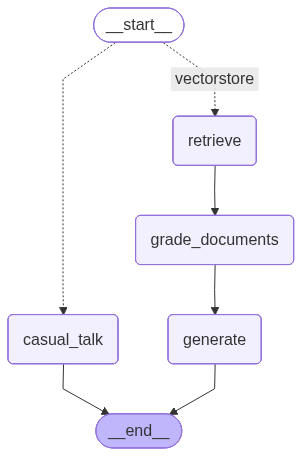

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))

except Exception:
    pass